### Covid case forecasting Using TimeSeriesModel

#### 1. Import Libraries

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata

#### 2. Accessing the Dataset

In [1]:
# Access the data table
data_table = r'covid_confirmed_usafacts.csv'

In [3]:
# Read the csv file
confirmed = pd.read_csv(data_table)
confirmed.head()

,countyFIPS,County Name,State,StateFIPS,22-01-2020,23-01-2020,24-01-2020,25-01-2020,26-01-2020,27-01-2020,28-01-2020,29-01-2020,30-01-2020,31-01-2020,01-02-2020,02-02-2020,03-02-2020,04-02-2020,05-02-2020,06-02-2020,07-02-2020,08-02-2020,09-02-2020,10-02-2020,11-02-2020,12-02-2020,13-02-2020,14-02-2020,15-02-2020,16-02-2020,17-02-2020,18-02-2020,19-02-2020,20-02-2020,21-02-2020,22-02-2020,23-02-2020,24-02-2020,25-02-2020,26-02-2020,...,24-12-2021,25-12-2021,26-12-2021,27-12-2021,28-12-2021,29-12-2021,30-12-2021,31-12-2021,01-01-2022,02-01-2022,03-01-2022,04-01-2022,05-01-2022,06-01-2022,07-01-2022,08-01-2022,09-01-2022,10-01-2022,11-01-2022,12-01-2022,13-01-2022,14-01-2022,15-01-2022,16-01-2022,17-01-2022,18-01-2022,19-01-2022,20-01-2022,21-01-2022,22-01-2022,23-01-2022,24-01-2022,25-01-2022,26-01-2022,27-01-2022,28-01-2022,29-01-2022,30-01-2022,31-01-2022,01-02-2022
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10758,10758,10758,10800,10828,10886,10953,11018,11018,11018,11018,11347,11478,11638,11789,11789,11789,12029,12102,12180,12180,12180,12180,12180,12682,12738,12833,12928,13019,13019,13019,13251,13251,13251,13251,13251,13251,13251,13251,14826
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38771,38771,38771,38942,39084,39298,39583,39911,39911,39911,39911,40838,41312,41855,42391,42391,42391,43583,43896,44353,44353,44353,44353,44353,46893,47143,47662,48338,49168,49168,49168,50313,50313,50313,50313,50313,50313,50313,50313,53083
3,1005,Barbour County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3735,3735,3735,3742,3750,3777,3819,3860,3860,3860,3860,3999,4036,4101,4150,4150,4150,4305,4375,4437,4437,4437,4437,4437,4713,4741,4800,4843,4902,4902,4902,5054,5054,5054,5054,5054,5054,5054,5054,5297
4,1007,Bibb County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4410,4410,4410,4426,4452,4472,4514,4533,4533,4533,4533,4616,4680,4730,4815,4815,4815,4939,5007,5046,5046,5046,5046,5046,5302,5385,5486,5565,5663,5663,5663,5795,5795,5795,5795,5795,5795,5795,5795,6158


#### 3. Raw Data Cleaning

In [4]:
# Extract the data of Alabama State
confirmed_AL = confirmed.loc[
    (confirmed["countyFIPS"] >= 1000) & (confirmed["countyFIPS"] <= 1133)]

In [5]:
# Stack the table for cumulative confirmed cases
confirmed_AL = confirmed_AL.set_index(["countyFIPS"])
confirmed_AL = confirmed_AL.drop(columns=["State", "County Name", "StateFIPS"])
confirmed_stacked_df = (
    confirmed_AL.stack()
    .reset_index()
    .rename(columns={"level_1": "OriginalDate", 0: "ConfirmedCases"})
)
confirmed_stacked_df

,countyFIPS,OriginalDate,ConfirmedCases
0,1001,22-01-2020,0
1,1001,23-01-2020,0
2,1001,24-01-2020,0
3,1001,25-01-2020,0
4,1001,26-01-2020,0
...,...,...,...
49709,1133,28-01-2022,6323
49710,1133,29-01-2022,6323
49711,1133,30-01-2022,6323
49712,1133,31-01-2022,6323


In [6]:
# Converting into date time field format
confirmed_stacked_df["DateTime"] = pd.to_datetime(
    confirmed_stacked_df["OriginalDate"], infer_datetime_format=True
)
confirmed_stacked_df = confirmed_stacked_df.drop(columns=["OriginalDate"])
confirmed_stacked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49714 entries, 0 to 49713
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   countyFIPS      49714 non-null  int64         
 1   ConfirmedCases  49714 non-null  int64         
 2   DateTime        49714 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


##### 3.1. Calculate Moving Average for Confirmed Cases

In [7]:
# Set moving average window = 7 days
SMA_Window = 7
# Copy the dataframe and set columns need to be calculated
df = confirmed_stacked_df
cols = {1: "ConfirmedCases"}

In [8]:
SMA_Window = 7
for fips in df.countyFIPS.unique():
    for col in cols:
        field = f"{cols[col]}_SMA{SMA_Window}"
        df.loc[df["countyFIPS"] == fips, field] = (
            df.loc[df["countyFIPS"] == fips]
            .iloc[:, col]
            .rolling(window=SMA_Window)
            .mean()
        )

##### 3.2. Cut Off first 6 day's date

In [9]:
firstMADay = df["DateTime"].iloc[0] + pd.DateOffset(days=SMA_Window - 1)
firstMADay

Timestamp('2020-01-28 00:00:00')

In [10]:
df_FirstMADay = df.loc[df["DateTime"] >= firstMADay]
df_FirstMADay.reset_index(drop=True, inplace=True)
df_FirstMADay

,countyFIPS,ConfirmedCases,DateTime,ConfirmedCases_SMA7
0,1001,0,2020-01-28,0.000000
1,1001,0,2020-01-29,0.000000
2,1001,0,2020-01-30,0.000000
3,1001,0,2020-01-31,0.000000
4,1001,0,2020-02-01,0.000000
...,...,...,...,...
49307,1133,6323,2022-01-28,6248.714286
49308,1133,6323,2022-01-29,6285.857143
49309,1133,6323,2022-01-30,6323.000000
49310,1133,6323,2022-01-31,6323.000000


#### 4. Time Series Data Preprocessing

In [11]:
# Selecting the required columns for modeling
df = df_FirstMADay[["DateTime", "ConfirmedCases_SMA7", "countyFIPS"]].copy()
df.columns = ["date", "cases", "countyFIPS"]
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")

In [12]:
df.tail()

,date,cases,countyFIPS
49307,2022-01-28,6248.714286,1133
49308,2022-01-29,6285.857143,1133
49309,2022-01-30,6323.000000,1133
49310,2022-01-31,6323.000000,1133
49311,2022-02-01,6427.857143,1133


##### 4.1. Collecting the counties of Alabama

In [13]:
# This cell collects all counties by their Unique FIPS IDs.
counties = df.countyFIPS.unique()
counties = [county for county in counties if county != 0]
len(counties)

67

#### 5. Time series modeling and forecasting

In [14]:
# This function selects the specified county data and splits the train and test data
def CountyData(county, test_size):
    data_file = df[df["countyFIPS"] == county]
    data_file.reset_index(inplace=True, drop=True)
    train, test = train_test_split(data_file, test_size=test_size, shuffle=False)
    return train, test 

In [15]:
def Model(train, seq_len, test_size):
    data = prepare_tabulardata(
        train, variable_predict="cases", index_field="date", seed=42
    )  # Preparing the tabular data
    tsmodel = TimeSeriesModel(
        data, seq_len=seq_len, model_arch="InceptionTime"
    )  # Model initialization
    lr_rate = tsmodel.lr_find()  # Finding the Learning rate
    tsmodel.fit(100, lr=lr_rate, checkpoint=False)  # Model training
    sdf_forecasted = tsmodel.predict(
        train, prediction_type="dataframe", number_of_predictions=test_size
    )  # Forecasting using the trained TimeSeriesModel
    return sdf_forecasted

In [16]:
# This function evalutes the model metrics and returns the dictionary
def evaluate(test, sdf_forecasted):
    r2_test = r2_score(test["cases"], sdf_forecasted["cases_results"][-14:])
    mse = metrics.mean_squared_error(
        test["cases"], sdf_forecasted["cases_results"][-14:]
    )
    mae = metrics.mean_absolute_error(
        test["cases"], sdf_forecasted["cases_results"][-14:]
    )
    return {
        "DATE": test["date"],
        "cases_actual": test["cases"],
        "cases_predicted": sdf_forecasted["cases_results"][-14:],
        "R-square": round(r2_test, 2),
        "V_RMSE": round(np.sqrt(mse), 4),
        "MAE": round(mae, 4),
    }

In [17]:
# This class calls all the defined functions
class CovidModel(object):
    seq_len = 15
    test_size = 14

    def __init__(self, county):
        self.county = county

    def CountyData(self):
        self.train, self.test = CountyData(self.county, self.test_size)

    def Model(self):
        self.sdf_forecasted = Model(self.train, self.seq_len, self.test_size)

    def evaluate(self):
        return evaluate(self.test, self.sdf_forecasted)

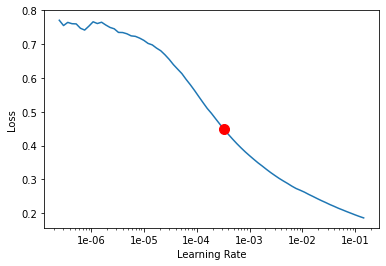

epoch     train_loss  valid_loss  time    
0         0.562610    0.179857    00:04     
1         0.436213    0.197112    00:05     


KeyboardInterrupt: 

In [18]:
# Training the model for all counties and saving the metrics in the dictionary.
dct = {}

for i, county in enumerate(counties):
    covidmodel = CovidModel(county)
    covidmodel.CountyData()
    covidmodel.Model()
    dct[county] = covidmodel.evaluate()

#### 6. Result visualization

In [19]:
# Specifying few counties for visualizing the results
viz_counties = [1007,1113]

for i, county in enumerate(viz_counties):
    result_df = pd.DataFrame(dct[county])
    plt.figure(figsize=(20, 5))
    plt.plot(result_df["DATE"], result_df[["cases_actual", "cases_predicted"]])
    plt.xlabel("Date")
    plt.ylabel("Covid Cases")
    plt.legend(["Cases_Actual", "Cases_Predicted"], loc="upper left")
    plt.title(str(county) + ": Covid Forecast Result")
    plt.show()

KeyError: 1007